In [234]:
#Project Imports

import pandas as pd
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from functools import reduce



from sklearn.linear_model import LinearRegression,Lasso,Ridge,RidgeCV,LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier


from sklearn import neighbors


from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances



from functools import reduce
from datetime import timezone, datetime,date
import pytz

pac = pytz.timezone('America/Los_Angeles')
utc = pytz.timezone('UTC')
%matplotlib inline

In [235]:
#Project Helper Functions
def Kel_To_Far(k):
    f = 1.8*(k - 273) + 32
    return f


Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

In [236]:
#Load Bike Data and rename columns
fre = './Data/Bike_Counts/Fremont_Bridge.csv'
fremont = pd.read_csv(fre,parse_dates = [0],index_col='Date')

fremont.rename(columns = {'Fremont Bridge East Sidewalk' : 'EastSide',
                         'Fremont Bridge West Sidewalk':'WestSide'
                         } , inplace= True)

fremont.index.names =['Date_Join']


#Set Timezone. Records already in pac but need to localize
fremont = fremont.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')

#Fill NA values with mean
fremont['EastSide'].fillna(value = fremont['EastSide'].mean(),inplace = True)
fremont['WestSide'].fillna(value = fremont['WestSide'].mean(),inplace = True)


#calculated columns
fremont['Mean_Xing'] = fremont[['EastSide','WestSide']].mean(axis=1)
fremont['Time_of_Day'] = fremont.index.strftime('%H')


#fremont.head(5)
print('You have Bridge data from {} to {}'.format(fremont.index.min().strftime('%m/%d/%Y'),fremont.index.max().strftime('%m/%d/%Y')))


You have Bridge data from 10/03/2012 to 04/30/2019


In [237]:
#load Weather Data
path = './Data/OpenWeatherMap/OpenWeatherMap_Seattle_Bulk.csv'
WX = pd.read_csv(path)

#format date column and set as index. Convert to Pacifict time. Original data in UTC
WX['dt_iso']=pd.to_datetime(WX['dt_iso'], format = '%Y-%m-%d %H:%M:%S +%f %Z' )
WX = WX.set_index('dt_iso')
WX = WX.tz_convert(pac)
WX.index.names =['Date_Join']


#convert temps from Kelving to Farenheit
WX['temp_f'] = WX.temp.apply(Kel_To_Far)
WX['temp_min_f'] = WX.temp_min.apply(Kel_To_Far)
WX['temp_max_f'] = WX.temp_max.apply(Kel_To_Far)



#drop unused column and re-order logically
WX.drop(['lat','lon','city_id','city_name','temp','temp_min','temp_max','sea_level','grnd_level','dt','weather_icon'],axis = 1,inplace=True)
WX.drop(['rain_3h','snow_3h','rain_24h','snow_24h','rain_today','snow_today'],axis = 1,inplace=True)
WX.drop(['weather_main','weather_id'],axis = 1,inplace=True)
 
neworder =['temp_f','temp_min_f','temp_max_f','pressure', 'humidity', 'wind_speed', 'wind_deg',
            'rain_1h','snow_1h', #'rain_3h','snow_3h','rain_24h','snow_24h', 'rain_today','snow_today',
            'clouds_all','weather_description'#, 'weather_main','weather_id'
          ]
WX=WX.reindex(columns=neworder)


#fill NA data with 0
WX['rain_1h'].fillna(value = 0,inplace = True)
WX['snow_1h'].fillna(value = 0,inplace =True)

#Calculated Columns
WX['Time_of_Day'] = WX.index.strftime('%H')
WX['Month'] = WX.index.strftime('%m')
WX['WeekDay'] = WX.index.strftime('%A')
WX['Season'] = WX.index.to_series().apply(get_season)

#Dummy Columns
WX = pd.get_dummies(data=WX,columns = ['weather_description','Season','Time_of_Day','Month','WeekDay'])


#WX.head(5)
print('You have weather data from {} to {}'.format(WX.index.min().strftime('%m/%d/%Y'),WX.index.max().strftime('%m/%d/%Y')))

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.


You have weather data from 10/01/2012 to 06/13/2019


In [238]:
WX.columns

Index(['temp_f', 'temp_min_f', 'temp_max_f', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_description_SQUALLS', 'weather_description_Sky is Clear',
       'weather_description_broken clouds', 'weather_description_drizzle',
       'weather_description_few clouds', 'weather_description_fog',
       'weather_description_haze',
       'weather_description_heavy intensity drizzle',
       'weather_description_heavy intensity rain',
       'weather_description_heavy intensity shower rain',
       'weather_description_heavy snow',
       'weather_description_light intensity drizzle',
       'weather_description_light intensity shower rain',
       'weather_description_light rain',
       'weather_description_light shower sleet',
       'weather_description_light shower snow',
       'weather_description_light snow', 'weather_description_mist',
       'weather_description_moderate rain',
       'weather_description_overcast clouds

In [239]:
#Load Air Quality Data. Combine date and time column. Localize, already in PAC
path = './Data/Air_Quality/Seattle_Air_Quality.csv'
air = pd.read_csv(path,parse_dates=[['Date', 'Time']],index_col = 'Date_Time')
air = air.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
air.index.names =['Date_Join']

#Drop columns
air.drop(['Wind Spd S','Wind Dir S','Temp Amb 10m','UV_633','BC_633','Trace CO'],axis = 1,inplace=True)

#Fill na values with q quantile
q = .25
air.NO.fillna(value = air.NO.quantile(q),inplace = True)
air.NO2.fillna(value = air.NO2.quantile(q),inplace = True)
air.NOX.fillna(value = air.NOX.quantile(q),inplace = True)
air.BAM_PM25.fillna(value = air.BAM_PM25.quantile(q),inplace = True)


print('You have Air data from {} to {}'.format(air.index.min().strftime('%m/%d/%Y'),air.index.max().strftime('%m/%d/%Y')))




You have Air data from 10/03/2012 to 04/30/2019


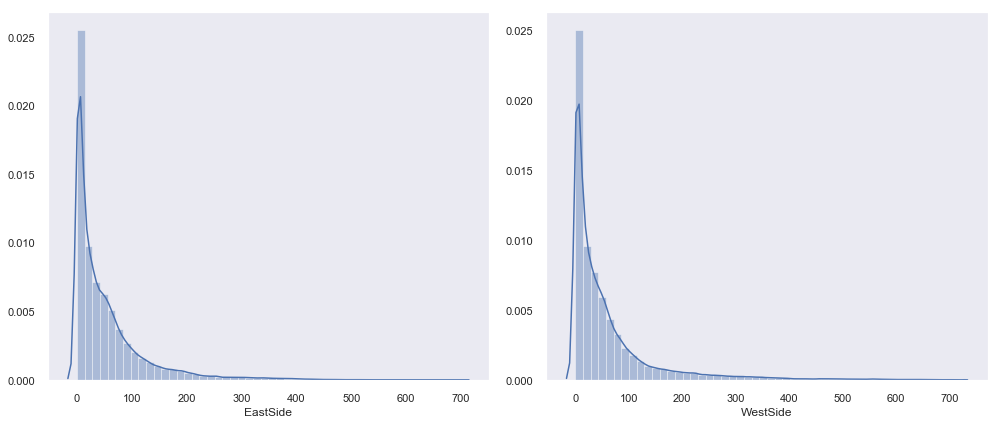

In [240]:
#histogram of bridge crossings
fig, axes = plt.subplots(nrows=1, ncols=2,figsize = [14,6])
sns.distplot(fremont['EastSide'],ax=axes[0])
sns.distplot(fremont['WestSide'],ax=axes[1])
plt.tight_layout();

In [241]:
fremont.sort_values(by='WestSide',ascending =False).head(25)

,EastSide,WestSide,Mean_Xing,Time_of_Day
Date_Join,,,,
2016-05-10 17:00:00-07:00,240.0,717.0,478.5,17
2018-05-23 17:00:00-07:00,215.0,709.0,462.0,17
2018-08-07 17:00:00-07:00,203.0,703.0,453.0,17
2018-05-14 17:00:00-07:00,205.0,698.0,451.5,17
2017-05-22 17:00:00-07:00,217.0,696.0,456.5,17
2018-05-15 17:00:00-07:00,213.0,694.0,453.5,17
2018-07-24 17:00:00-07:00,200.0,691.0,445.5,17
2016-05-02 17:00:00-07:00,261.0,691.0,476.0,17
2018-06-19 17:00:00-07:00,188.0,685.0,436.5,17


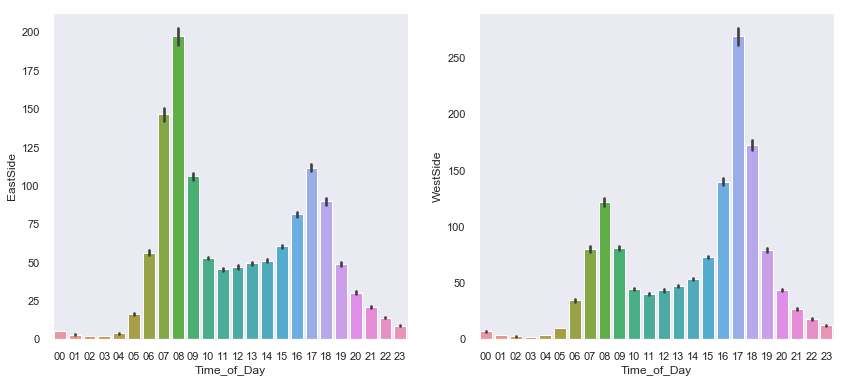

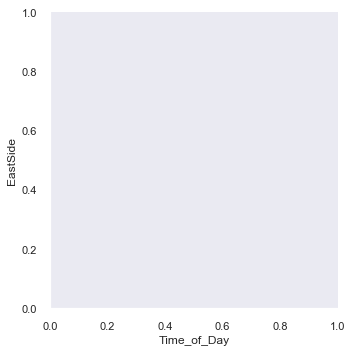

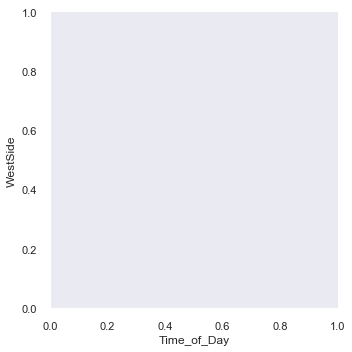

In [242]:
#cat plot of east and west crossings. Average per hour?
fig, axes = plt.subplots(nrows=1, ncols=2,figsize = [14,6])
sns.catplot(x="Time_of_Day",y="EastSide",data=fremont,kind='bar',sharey=True,ax=axes[0] )
sns.catplot(x="Time_of_Day",y="WestSide",data=fremont,kind='bar',sharey=True,ax=axes[1])
plt.tight_layout();

In [243]:
#merge DF's together on Pacifict TZ date_Join column

dfs = (fremont,WX,air)
data = reduce(lambda left,right: pd.merge(left,right,on = 'Date_Join'),dfs)

print('You have combined data from {} to {}'.format(data.index.min().strftime('%m/%d/%Y'),data.index.max().strftime('%m/%d/%Y')))
print(len(data),'Observations')

You have combined data from 10/03/2012 to 04/30/2019
55523 Observations


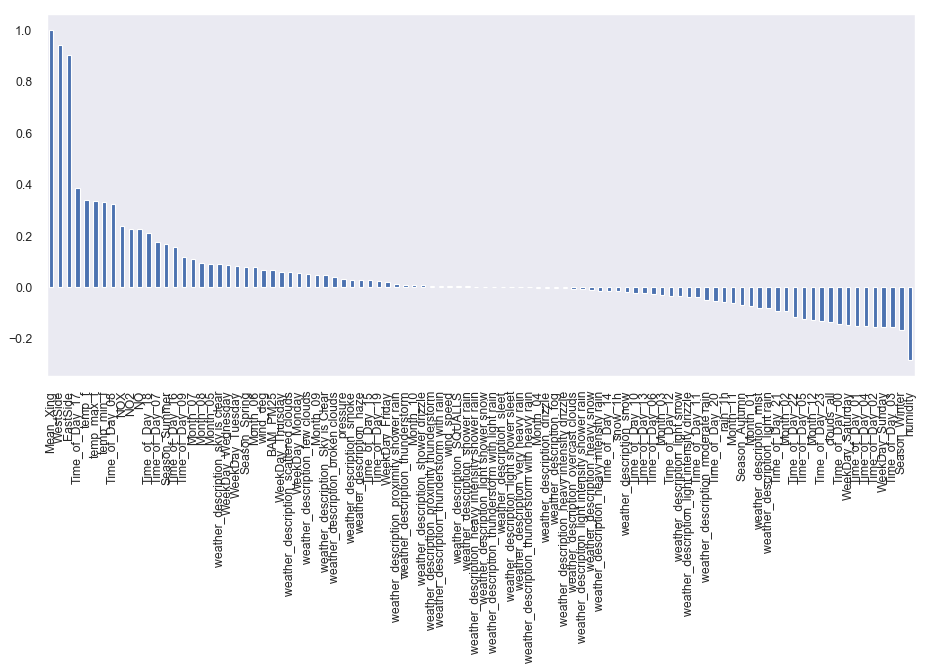

In [244]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
corr = data.corr()
corr['Mean_Xing'].sort_values(ascending=False).plot(kind='bar');

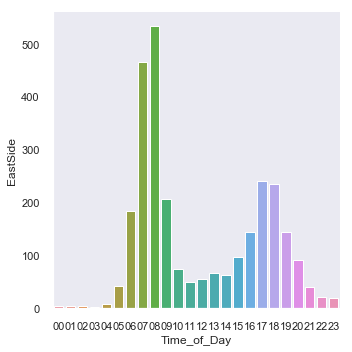

In [247]:
#look at crossings for a specific day
plot=data[['EastSide','WestSide','Time_of_Day']].loc['2016-05-10']

#plot
sns.catplot(x="Time_of_Day",y="EastSide",data=plot,kind='bar',sharey=True);


In [270]:
features = [
'temp_f',
#'temp_min_f',
#'temp_max_f',
#'pressure',
'humidity',
#'wind_speed',
#'wind_deg',
'rain_1h',
'snow_1h',
'clouds_all',
'weather_description_SQUALLS',
'weather_description_Sky is Clear',
'weather_description_broken clouds',
'weather_description_drizzle',
'weather_description_few clouds',
'weather_description_fog',
'weather_description_haze',
'weather_description_heavy intensity drizzle',
'weather_description_heavy intensity rain',
'weather_description_heavy intensity shower rain',
'weather_description_heavy snow',
'weather_description_light intensity drizzle',
'weather_description_light intensity shower rain',
'weather_description_light rain',
'weather_description_light shower sleet',
'weather_description_light shower snow',
'weather_description_light snow',
'weather_description_mist',
'weather_description_moderate rain',
'weather_description_overcast clouds',
'weather_description_proximity shower rain',
'weather_description_proximity thunderstorm',
'weather_description_scattered clouds',
'weather_description_shower drizzle',
'weather_description_shower rain',
'weather_description_sky is clear',
'weather_description_sleet',
'weather_description_smoke',
'weather_description_snow',
'weather_description_thunderstorm',
'weather_description_thunderstorm with heavy rain',
'weather_description_thunderstorm with light rain',
'weather_description_thunderstorm with rain',
'weather_description_very heavy rain',
#'Season_Autumn',
#'Season_Spring',
#'Season_Summer',
#'Season_Winter',
'Time_of_Day_00',
'Time_of_Day_01',
'Time_of_Day_02',
'Time_of_Day_03',
'Time_of_Day_04',
'Time_of_Day_05',
'Time_of_Day_06',
'Time_of_Day_07',
'Time_of_Day_08',
'Time_of_Day_09',
'Time_of_Day_10',
'Time_of_Day_11',
'Time_of_Day_12',
'Time_of_Day_13',
'Time_of_Day_14',
'Time_of_Day_15',
'Time_of_Day_16',
'Time_of_Day_17',
'Time_of_Day_18',
'Time_of_Day_19',
'Time_of_Day_20',
'Time_of_Day_21',
'Time_of_Day_22',
'Time_of_Day_23',
'Month_01',
'Month_02',
'Month_03',
'Month_04',
'Month_05',
'Month_06',
'Month_07',
'Month_08',
'Month_09',
'Month_10',
'Month_11',
'Month_12',
'WeekDay_Monday',
'WeekDay_Tuesday',
'WeekDay_Wednesday',
'WeekDay_Thursday',
'WeekDay_Friday',
'WeekDay_Saturday',
'WeekDay_Sunday',
'NO',
'NO2',
'NOX',
'BAM_PM25'
]

In [271]:
X = data[features]
#y = data['EastSide']
y = data['WestSide']
#y = data['Mean_Xing']


scaler = StandardScaler()
X_std = scaler.fit_transform(X)


C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state= 23)
#X_train, X_test, y_train, y_test = train_test_split(X_std, y,random_state= 23)
y_baseline = [data.Mean_Xing.mean()] * len(y_test)


print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(len(y_baseline))

(41642, 86)
(41642,)
(13881, 86)
(13881,)
13881


In [273]:
#X_train.dtypes#sample(15) #DF Index
#X_test.sample(15) #DF Index
#y_test.sort_values()#tail(15) #series Index
#y_train.sample(15) #series Index

In [282]:
#model = LinearRegression()
#model = LogisticRegression()
#model = Lasso(alpha=10)
model = Ridge(alpha=10)
#model = RidgeCV()###Ridge with cross validation built in???
#model = neighbors.KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#save model coeficients
coef = Series(model.coef_,features).sort_values(ascending=False)

#set negative predictons to 0???
#y_pred[y_pred < 0] = 10

print("R-squared = ", model.score(X_test, y_test)) 
print("RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Baseline RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_baseline)))


R-squared =  0.6416320337660079
RMSE =  50.11546006955451
Baseline RMSE =  83.81962701721024


In [278]:
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.22779e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.6362e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.32844e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.572e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.69055e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\cody

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.80629e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.42548e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.75757e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.2805e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.8915e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\cod

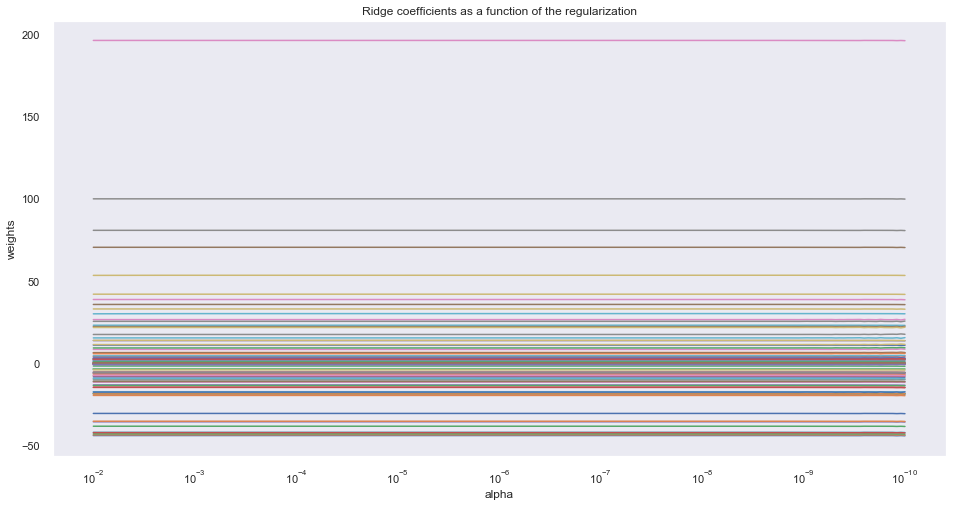

In [279]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

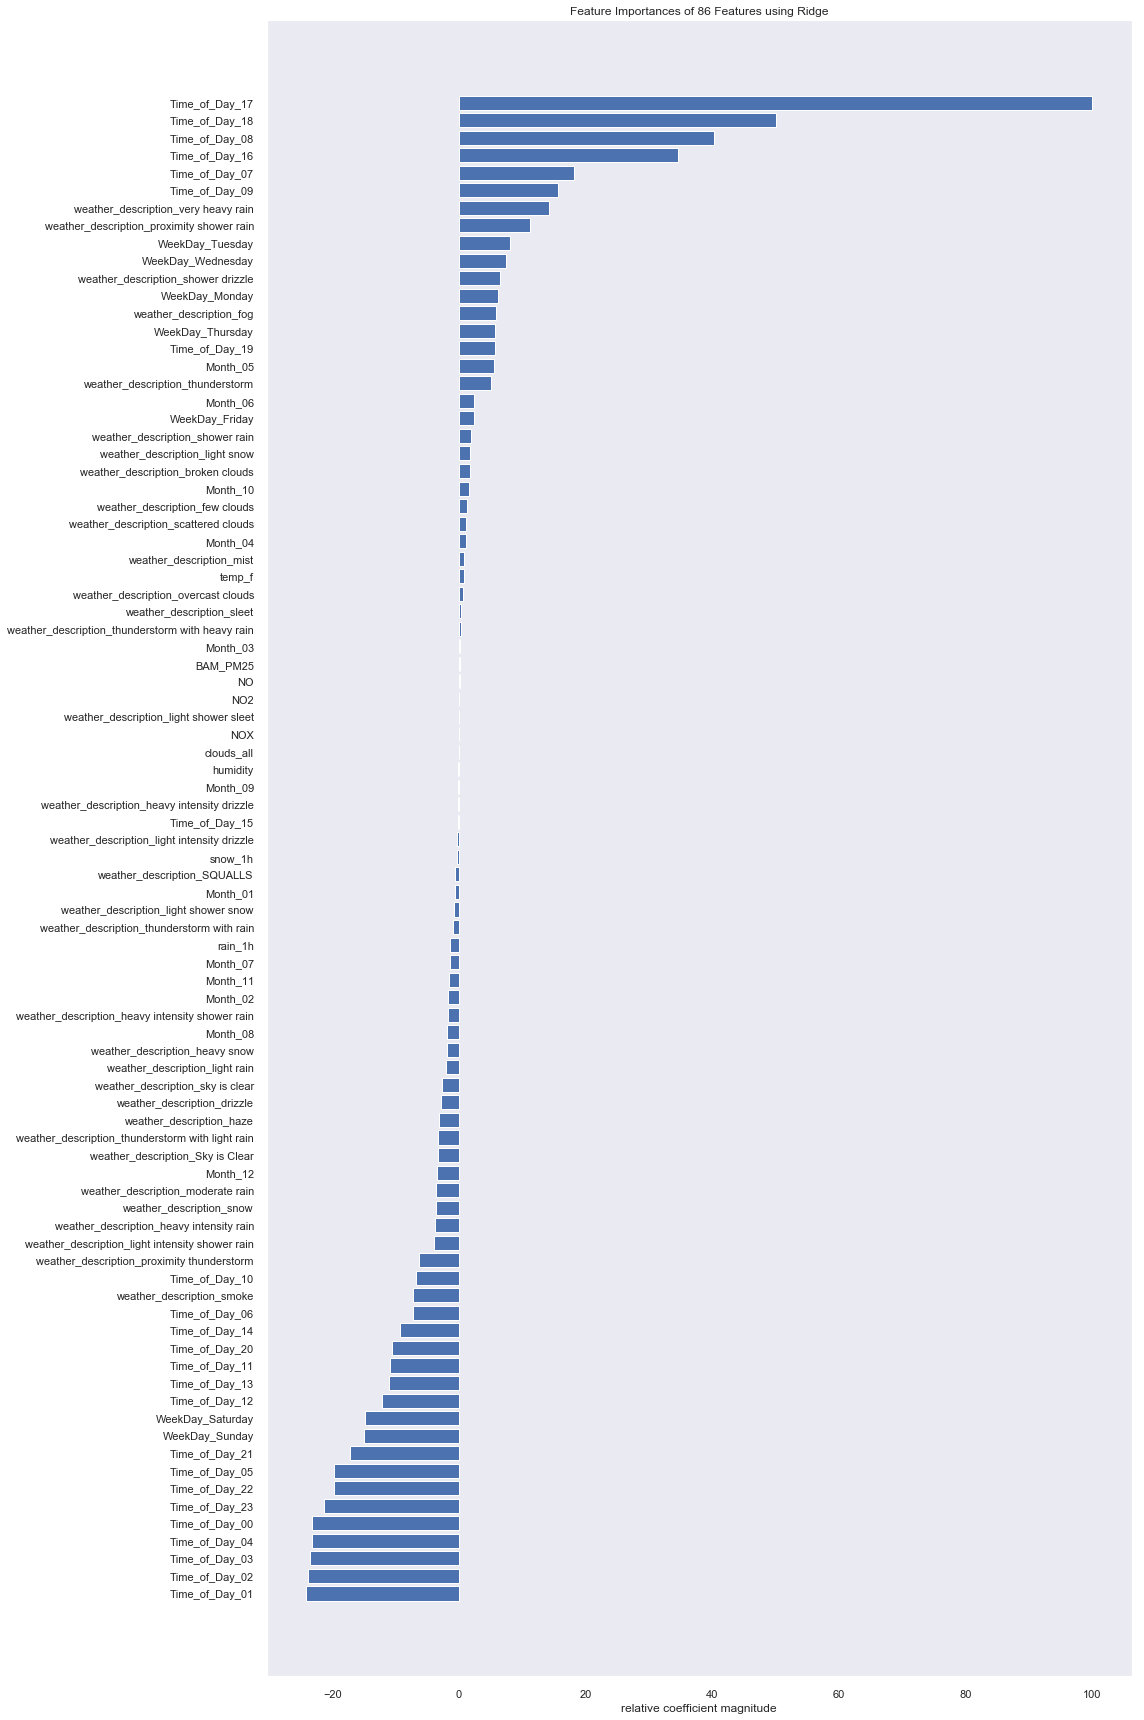

In [275]:
plt.rcParams['figure.figsize'] = (16, 24)
ax = fig.add_subplot()

visualizer = FeatureImportances(model)
visualizer.fit(X_train, y_train)
visualizer.poof()

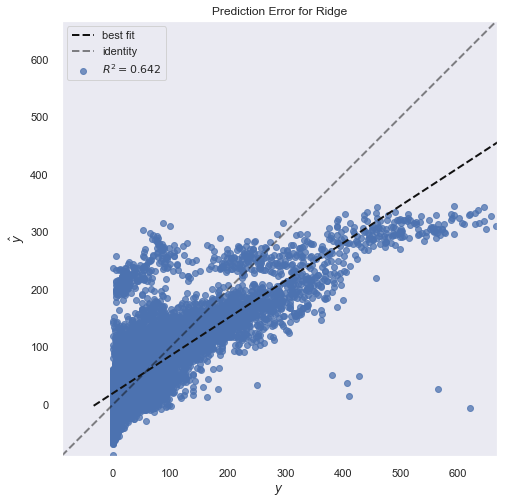

In [276]:
plt.rcParams['figure.figsize'] = (16, 8)

visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

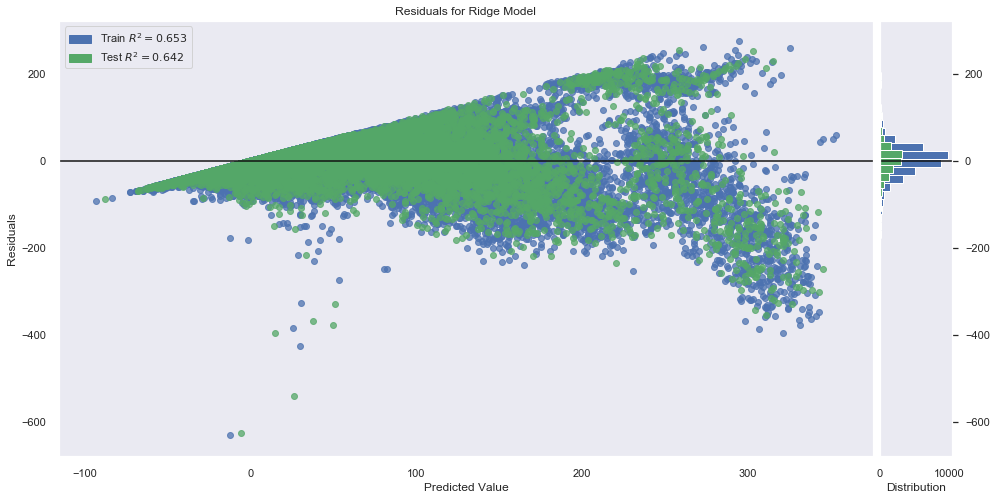

In [277]:
plt.rcParams['figure.figsize'] = (16, 8)

visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [199]:
#plt.scatter(y_test,y_pred)
#plt.xlabel('True Values')
#plt.ylabel('Predictions')